# *Load Data*

In [3]:
# xgboost version 要小 
!pip uninstall xgboost 
!pip install xgboost==1.2.1

In [4]:
import xgboost
print( xgboost.__version__ )

1.7.1


In [12]:
from sklearn import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from joblib import Parallel, delayed
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [6]:
# load dataset
train_data_path = './data/sign_mnist_train.csv'
test_data_path = './data/sign_mnist_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_X = np.array(train_data[train_data.columns[1:]])
trainY = np.array(train_data['label'])

test_X = np.array(test_data[test_data.columns[1:]])
testY = np.array(test_data['label'])

label_index = 'ABCDEFGHIKLMNOPQRSTUVWXY'
labels = np.unique(np.array(train_data['label']))
print(train_data.shape)
print(test_data.shape)
print(np.unique(np.array(train_data['label'])))

(27455, 785)
(7172, 785)
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


<BarContainer object of 24 artists>

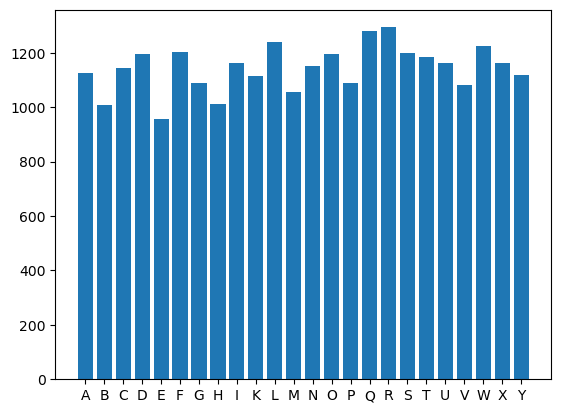

In [7]:
class_count = np.array(train_data.groupby('label').agg('count')['pixel1'])
x_axis = [idx for idx in label_index if idx not in 'JZ']
plt.bar(x_axis, class_count)

# *Feature Representations*

In [8]:
## 1.feature normalization (StandardScaler)
scaler = preprocessing.StandardScaler()
train_X1 = scaler.fit_transform(train_X)
test_X1 = scaler.transform(test_X)
print(train_X)
print(train_X1)
print(test_X)
print(test_X1)

[[107 118 127 ... 204 203 202]
 [155 157 156 ... 103 135 149]
 [187 188 188 ... 195 194 195]
 ...
 [174 174 174 ... 202 200 200]
 [177 181 184 ...  64  87  93]
 [179 180 180 ... 205 209 215]]
[[-0.92895113 -0.76362507 -0.62085156 ...  0.66406257  0.65811336
   0.65493948]
 [ 0.23165213  0.2128048   0.12168008 ... -0.93157535 -0.41091344
  -0.16809718]
 [ 1.00538763  0.98894136  0.94102534 ...  0.52187701  0.51662452
   0.54623652]
 ...
 [ 0.69105758  0.63842807  0.58256179 ...  0.63246578  0.61095041
   0.62388149]
 [ 0.76359529  0.81368471  0.83860719 ... -1.54771277 -1.16552059
  -1.03772083]
 [ 0.81195376  0.78864805  0.73618903 ...  0.67986097  0.75243925
   0.8568164 ]]
[[149 149 150 ... 112 120 107]
 [126 128 131 ... 184 182 180]
 [ 85  88  92 ... 225 224 222]
 ...
 [190 191 190 ... 211 209 208]
 [201 205 208 ...  67  70  63]
 [173 174 173 ... 195 193 192]]
[[ 0.08657672  0.01251149 -0.03194715 ... -0.78938979 -0.64672817
  -0.82031492]
 [-0.46954568 -0.51325843 -0.5184334  ...  

# *1. Logistic Regression Classifier*

In [9]:
# Test Accuracy VS different n_components
pca = decomposition.PCA()
train_X2 = pca.fit_transform(train_X1)
test_X2 = pca.transform(test_X1)
print(train_X2.shape)
print(test_X2.shape)
Xdim = train_X2.shape[1]

(27455, 784)
(7172, 784)


In [6]:
# get best parameters by cross-validation
log_cv = linear_model.LogisticRegressionCV(Cs=np.logspace(-3,3,20), cv=5,n_jobs =4)
log_cv.fit(train_X2, trainY)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegressionCV(Cs=array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                     cv=5, n_jobs=4)

In [7]:
print("------Staring--------")
def LG_pca(j):
    trainX_jd = train_X2[:,0:j]
    testX_jd = test_X2[:,0:j]
    # Model with best parameters in the range
    model = linear_model.LogisticRegression(C=log_cv.C_[0])
    model.fit(trainX_jd,trainY)
    return metrics.accuracy_score(testY, model.predict(testX_jd))
    
result = Parallel(n_jobs=4)(delayed(LG_pca)(j) for j in range(50,Xdim,50))
acc = np.array(result)

------Staring--------


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [8]:
print(linear_model.LogisticRegression(C=log_cv.C_[0]))

LogisticRegression(C=2.976351441631316)


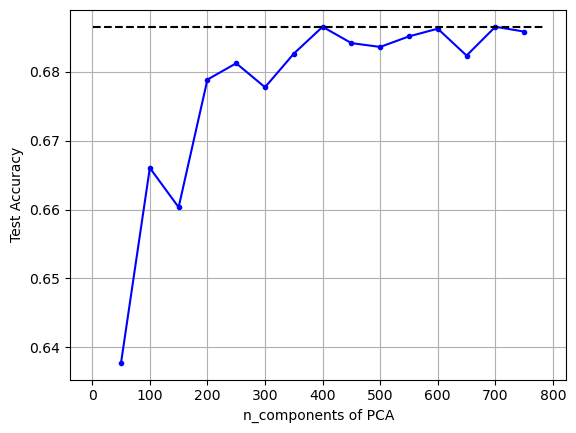

In [9]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

In [10]:
df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)

    n_components  Test Accuracy
0             50       0.637758
1            100       0.666062
2            150       0.660346
3            200       0.678890
4            250       0.681260
5            300       0.677775
6            350       0.682655
7            400       0.686559
8            450       0.684189
9            500       0.683631
10           550       0.685165
11           600       0.686280
12           650       0.682376
13           700       0.686559
14           750       0.685862


# *Bayes*

In [18]:
# 1.1 BernoulliNB Classifier
# use K-fold cross-validation to get best hyperparamter
alpha_space = np.logspace(-4,4,20)
mean_scores = []
max_score = 0.00
best_alpha_BernoulliNB = 0.00
for alpha_value in alpha_space:
    # build BernoulliNB model and fit data
    b_model = naive_bayes.BernoulliNB(alpha=alpha_value)
    b_model.fit(train_X2, trainY)
    mean_score = cross_val_score(b_model, train_X2, trainY, cv=5, n_jobs=4).mean()
    mean_scores.append(mean_score)
    if mean_score > max_score:
        best_alpha_BernoulliNB = alpha_value
        max_score = mean_score

# the best value of alpha using cross-validation
print("The best alpha =",best_alpha_BernoulliNB)

The best alpha = 11.288378916846883


In [20]:
print(naive_bayes.BernoulliNB(alpha=best_alpha_BernoulliNB))

BernoulliNB(alpha=11.288378916846883)


In [14]:
print("------Staring--------")
def BernoulliNB_pca(j):
    trainX_jd = train_X2[:,0:j]
    testX_jd = test_X2[:,0:j]
    # Model with best parameters in the range
    model = naive_bayes.BernoulliNB(alpha=best_alpha_BernoulliNB)
    model.fit(trainX_jd,trainY)
    return metrics.accuracy_score(testY, model.predict(testX_jd))
    
result = Parallel(n_jobs=4)(delayed(BernoulliNB_pca)(j) for j in range(50,Xdim,50))
acc = np.array(result)

------Staring--------


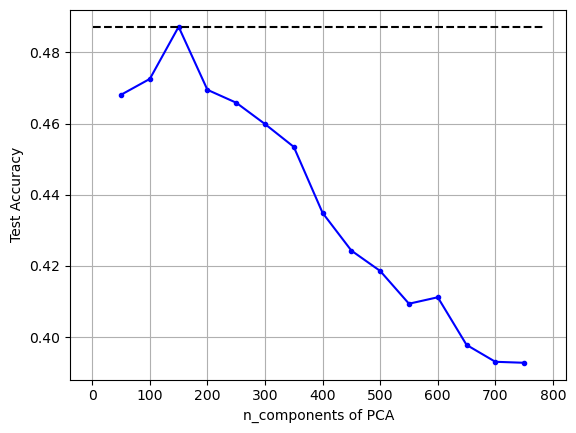

In [15]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

In [21]:
df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)

    n_components  Test Accuracy
0             50       0.468070
1            100       0.472532
2            150       0.487172
3            200       0.469465
4            250       0.465839
5            300       0.459844
6            350       0.453430
7            400       0.434886
8            450       0.424289
9            500       0.418572
10           550       0.409370
11           600       0.411182
12           650       0.397797
13           700       0.393056
14           750       0.392777


# *GaussianNB*

In [44]:
print("------Staring--------")
def GaussianNB_pca(j):
    trainX_jd = train_X2[:,0:j]
    testX_jd = test_X2[:,0:j]
    # Model with best parameters in the range
    model = naive_bayes.GaussianNB()
    model.fit(trainX_jd,trainY)
    return metrics.accuracy_score(testY, model.predict(testX_jd))
    
result = Parallel(n_jobs=4)(delayed(GaussianNB_pca)(j) for j in range(50,Xdim,50))
acc = np.array(result)

------Staring--------


    n_components  Test Accuracy
0             50       0.648355
1            100       0.623257
2            150       0.588260
3            200       0.552566
4            250       0.518823
5            300       0.485220
6            350       0.450641
7            400       0.416760
8            450       0.371166
9            500       0.347741
10           550       0.310792
11           600       0.281372
12           650       0.254601
13           700       0.232153
14           750       0.191578


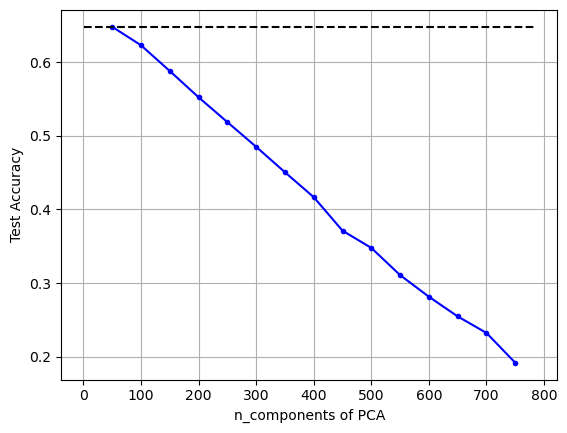

In [45]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)

# *MultinomialNB Classifier*

In [36]:
# min-max feature normalization (0-1)
scaler = preprocessing.MinMaxScaler()
train_X3 = scaler.fit_transform(train_X)
test_X3 = scaler.transform(test_X)
print(train_X)
print(train_X3)
print(test_X)
print(test_X3)

[[107 118 127 ... 204 203 202]
 [155 157 156 ... 103 135 149]
 [187 188 188 ... 195 194 195]
 ...
 [174 174 174 ... 202 200 200]
 [177 181 184 ...  64  87  93]
 [179 180 180 ... 205 209 215]]
[[0.41960784 0.4627451  0.49803922 ... 0.8        0.79607843 0.79215686]
 [0.60784314 0.61568627 0.61176471 ... 0.40392157 0.52941176 0.58431373]
 [0.73333333 0.7372549  0.7372549  ... 0.76470588 0.76078431 0.76470588]
 ...
 [0.68235294 0.68235294 0.68235294 ... 0.79215686 0.78431373 0.78431373]
 [0.69411765 0.70980392 0.72156863 ... 0.25098039 0.34117647 0.36470588]
 [0.70196078 0.70588235 0.70588235 ... 0.80392157 0.81960784 0.84313725]]
[[149 149 150 ... 112 120 107]
 [126 128 131 ... 184 182 180]
 [ 85  88  92 ... 225 224 222]
 ...
 [190 191 190 ... 211 209 208]
 [201 205 208 ...  67  70  63]
 [173 174 173 ... 195 193 192]]
[[0.58431373 0.58431373 0.58823529 ... 0.43921569 0.47058824 0.41960784]
 [0.49411765 0.50196078 0.51372549 ... 0.72156863 0.71372549 0.70588235]
 [0.33333333 0.34509804 0.

In [ ]:
# Test Accuracy VS different n_components
pca = decomposition.NMF()
train_X4 = pca.fit_transform(train_X3)
test_X4 = pca.transform(test_X3)
print(train_X4.shape)
print(test_X4.shape)

In [ ]:
# 1.2 MultinomialNB Classifier (need Min-Max Scaler & NMF Dimension Reduction)
# use K-fold cross-validation to get best hyperparamter
alpha_space = np.logspace(-4,4,20)
mean_scores = []
max_score= 0.00
best_alpha_MultinomialNB = 0.00
for alpha_value in alpha_space:
    # build MultinomialNB model and fit data
    m_model = naive_bayes.MultinomialNB(alpha=alpha_value)
    m_model.fit(train_X4, trainY)
    mean_score = cross_val_score(m_model, train_X4, trainY, cv=5, n_jobs=4).mean()
    mean_scores.append(mean_score)
    if mean_score > max_score:
        best_alpha_MultinomialNB = alpha_value
        max_score = mean_score

# the best value of alpha using cross-validation
print("The best alpha =",best_alpha_MultinomialNB)

In [30]:
print(naive_bayes.MultinomialNB(alpha=best_alpha_MultinomialNB))

MultinomialNB(alpha=11.288378916846883)


In [ ]:
print("------Staring--------")
def MultinomialNB_pca(j):
    trainX_jd = train_X4[:,0:j]
    testX_jd = test_X4[:,0:j]
    # Model with best parameters in the range
    model = naive_bayes.MultinomialNB(alpha=best_alpha_MultinomialNB)
    model.fit(trainX_jd,trainY)
    return metrics.accuracy_score(testY, model.predict(testX_jd))
    
result = Parallel(n_jobs=4)(delayed(MultinomialNB_pca)(j) for j in range(50,Xdim,50))
acc = np.array(result)

    n_components  Test Accuracy
0             50       0.468070
1            100       0.472532
2            150       0.487172
3            200       0.469465
4            250       0.465839
5            300       0.459844
6            350       0.453430
7            400       0.434886
8            450       0.424289
9            500       0.418572
10           550       0.409370
11           600       0.411182
12           650       0.397797
13           700       0.393056
14           750       0.392777


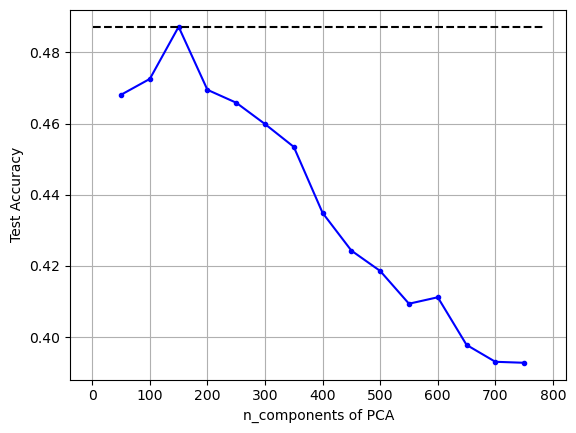

In [32]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)

# *SVM (kernel = 'lienar')*

In [11]:
# get best parameters by cross-validation
hyper_params = {'C':np.logspace(-3,3,12)}
svm_cv = GridSearchCV(SVC(kernel='linear'),hyper_params,cv=5,n_jobs =4)
svm_cv.fit(train_X2, trainY)
print(svm_cv)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'), n_jobs=4,
             param_grid={'C': array([1.00000000e-03, 3.51119173e-03, 1.23284674e-02, 4.32876128e-02,
       1.51991108e-01, 5.33669923e-01, 1.87381742e+00, 6.57933225e+00,
       2.31012970e+01, 8.11130831e+01, 2.84803587e+02, 1.00000000e+03])})


In [12]:
print("------Staring--------")
def SVM_pca(j):
    trainX_jd = train_X2[:,0:j]
    testX_jd = test_X2[:,0:j]
    # Model with best parameters in the range
    model = SVC(kernel='linear',C=svm_cv.best_params_.get('C'))
    model.fit(trainX_jd,trainY)
    return metrics.accuracy_score(testY, model.predict(testX_jd))
    
result = Parallel(n_jobs=4)(delayed(SVM_pca)(j) for j in range(50,Xdim,50))
acc = np.array(result)

------Staring--------


In [13]:
print(SVC(kernel='linear',C=svm_cv.best_params_.get('C')))

SVC(C=0.012328467394420659, kernel='linear')


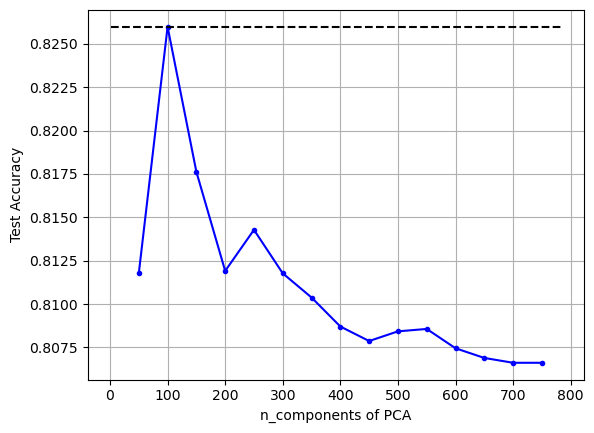

In [14]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

In [15]:
df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)

    n_components  Test Accuracy
0             50       0.811768
1            100       0.825990
2            150       0.817624
3            200       0.811907
4            250       0.814278
5            300       0.811768
6            350       0.810374
7            400       0.808701
8            450       0.807864
9            500       0.808422
10           550       0.808561
11           600       0.807446
12           650       0.806888
13           700       0.806609
14           750       0.806609


# *SVM (kernel = 'poly')*

In [ ]:
# # get best parameters by cross-validation
# hyper_params = {'C':np.logspace(-2,2,4)}
# svm_poly_cv = GridSearchCV(SVC(kernel='poly'),hyper_params,cv=5,n_jobs =4)
# svm_poly_cv.fit(train_X2, trainY)
# print(svm_poly_cv)

In [13]:
print("------Staring--------")
def SVM_poly_pca(j):
    trainX_jd = train_X2[:,0:j]
    testX_jd = test_X2[:,0:j]
    # Model with best parameters in the range
    model = SVC(kernel='poly')
    model.fit(trainX_jd,trainY)
    return metrics.accuracy_score(testY, model.predict(testX_jd))
    
result = Parallel(n_jobs=4)(delayed(SVM_poly_pca)(j) for j in range(50,Xdim,50))
acc = np.array(result)

------Staring--------


In [14]:
print(SVC(kernel='poly'))

SVC(kernel='poly')


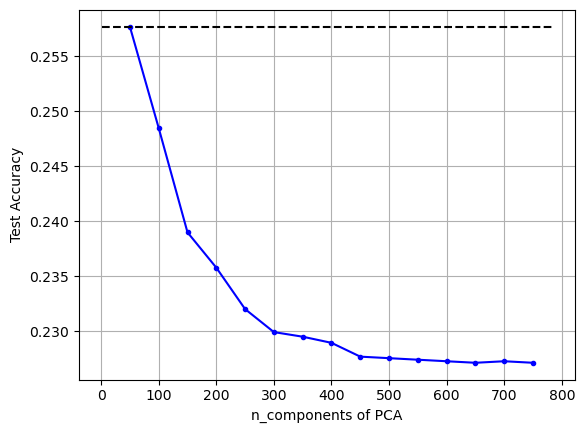

In [15]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

In [16]:
df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)

    n_components  Test Accuracy
0             50       0.257669
1            100       0.248466
2            150       0.238985
3            200       0.235778
4            250       0.232013
5            300       0.229922
6            350       0.229504
7            400       0.228946
8            450       0.227691
9            500       0.227552
10           550       0.227412
11           600       0.227273
12           650       0.227133
13           700       0.227273
14           750       0.227133


# *XgBoost*

In [ ]:
print("------Staring--------")
def xgboost_pca(j):
    trainX_jd = train_X2[:,0:j]
    testX_jd = test_X2[:,0:j]
    # Model with best parameters in the range
    model = XGBClassifier()
    model.fit(trainX_jd,trainY)
    print("Dimension:",j)
    return metrics.accuracy_score(testY, model.predict(testX_jd))
    
result = Parallel(n_jobs=4)(delayed(xgboost_pca)(j) for j in range(50,Xdim,50))
acc = np.array(result)

In [ ]:
print(XGBClassifier())

In [ ]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

In [ ]:
df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)

# *AdaBoost*

In [ ]:
print(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=7)))

In [ ]:
# make the plot
plt.plot(range(50,Xdim,50), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('n_components of PCA')
plt.ylabel('Test Accuracy');

In [ ]:
df = pd.DataFrame({'n_components': [*range(50,Xdim,50)], 'Test Accuracy':result}) 
# df.style.set_properties(**{'background-color': 'black', 
#                            'color': 'green'})
# df.style.highlight_max(axis=0)
print(df)